In [16]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
#Import data frame
path1 = r"/Users/shuhui_zhao/Desktop/credit_card_approval_prediction/credit_record.csv"
path2 = r"/Users/shuhui_zhao/Desktop/credit_card_approval_prediction/application_record.csv"
#
credit_df=pd.read_csv(path1)
#clients' application info
app_df=pd.read_csv(path2)

In [42]:
#print(credit_df.shape)
credit_df.head()
#print(credit_df)
print("Number of unique clients in application_record dataset: {}".format(len(credit_df.ID.unique())))

(1048575, 3)
              ID  MONTHS_BALANCE STATUS
0        5001711               0      X
1        5001711              -1      0
2        5001711              -2      0
3        5001711              -3      0
4        5001712               0      C
...          ...             ...    ...
1048570  5150487             -25      C
1048571  5150487             -26      C
1048572  5150487             -27      C
1048573  5150487             -28      C
1048574  5150487             -29      C

[1048575 rows x 3 columns]
Number of unique clients in application_record dataset: 45985


In [19]:
######Response variable
###Check missing value
credit_df = credit_df.dropna()
print(credit_df.shape) #apparantly, there is no missing data
#sort the data by customers' ID
credit_df.sort_values('ID')
###Check duplicates
#For each id, if there are two identical month, delete both observations
#temporary data frame: groups_month, groups_month_count
groups_month = credit_df.groupby(['ID','MONTHS_BALANCE'])
groups_month_count = groups_month.count()
groups_month_count = groups_month_count.rename(columns = {"STATUS":"COUNT"})
print(groups_month_count.loc[groups_month_count['COUNT']>1]) #no replicates


(1048575, 3)
Empty DataFrame
Columns: [COUNT]
Index: []


In [20]:
###Vintage analysis
#credit_df['MONTHS_BALANCE'].max()
#credit_df['MONTHS_BALANCE'].min()
#we are going to dig in the past 60 months, every 6 months
credit_grouped = credit_df.groupby('ID')

In [21]:
#reshape data by 'ID' based on 'MONTHS_BALANCE'
credit_pivot = credit_df.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
#print(credit_pivot.head())
#assume that the minimum value of 'MONTHS_BALANCE' is the open_month
#Similarly, assume that the maximum value of 'MONTHS_BALANCE' is the close_month
#group the credit_df by 'ID' and extract the minimum & maximum value of 'MONTHS_BALANCE'
credit_grouped = credit_df.groupby('ID')
credit_pivot['open_month'] = credit_grouped['MONTHS_BALANCE'].min()
credit_pivot['close_month'] = credit_grouped['MONTHS_BALANCE'].max()
credit_pivot['ID'] = credit_pivot.index
credit_pivot = credit_pivot[['ID','open_month','close_month']]
#to merge the data, 'ID' cannot be an index level
credit_pivot.reset_index(drop=True, inplace=True)
#calculate the window_month
credit_pivot["window_month"] = credit_pivot['close_month']-credit_pivot['open_month']

In [41]:
#print(credit_pivot)

MONTHS_BALANCE       ID  open_month  close_month  window_month
0               5001711          -3            0             3
1               5001712         -18            0            18
2               5001713         -21            0            21
3               5001714         -14            0            14
4               5001715         -59            0            59
...                 ...         ...          ...           ...
45980           5150482         -28          -11            17
45981           5150483         -17            0            17
45982           5150484         -12            0            12
45983           5150485          -1            0             1
45984           5150487         -29            0            29

[45985 rows x 4 columns]


In [22]:
#merge two data frame (LEFT OTTER JOIN)
credit = pd.merge(credit_df, credit_pivot, how = 'left', on = 'ID')
#save credit data frame in credit0 (in case)
credit0 = credit
#print(credit.head())

In [23]:
#divide 48 months into 8 half a year
credit
bins = [k for k in range(-61,1,12)]
credit['open_year'] = pd.cut(credit['open_month'],bins,labels = [-5,-4,-3,-2,-1])#open_year_to_today
#save credit data frame in credit0 (in case)
credit0 = credit
#According to IFRS 9, consider 12 months as performance window
credit = credit[credit['window_month']>12]
#print(credit.head())

In [43]:
print(credit)

              ID  MONTHS_BALANCE STATUS  open_month  close_month  \
22       5001712             -18      0         -18            0   
21       5001712             -17      0         -18            0   
20       5001712             -16      0         -18            0   
19       5001712             -15      0         -18            0   
18       5001712             -14      0         -18            0   
...          ...             ...    ...         ...          ...   
1048549  5150487              -4      C         -29            0   
1048548  5150487              -3      C         -29            0   
1048547  5150487              -2      C         -29            0   
1048546  5150487              -1      C         -29            0   
1048545  5150487               0      C         -29            0   

         window_month open_year  overdue  MOB  
22                 18        -2        0    0  
21                 18        -2        0    1  
20                 18        -2        

In [25]:
#denominator: number of customers who opened their account every months
credit_pivot_temp = credit_pivot.loc[credit_pivot['window_month']>12]
credit_pivot_temp = pd.merge(credit_pivot_temp, credit[['ID','open_year']],on = 'ID', how = 'left')
credit_pivot_temp = credit_pivot_temp[['ID','open_year','window_month']]
de = credit_pivot_temp.groupby('open_year').agg({'ID':pd.Series.nunique})
de = de.rename(columns = {"ID":"open_sum"})
de.reset_index(inplace=True)
#print(de.head())

In [27]:
###calculate the cumulative percentage of bad customers (cumulative charge-off rate/cumulative loss rate)

#A customer will be considered as 'bad' (1) if overdue
credit['overdue']=np.where((credit['STATUS']=='2')|(credit['STATUS']=='3')
                           |(credit['STATUS']=='4')|(credit['STATUS']=='5'),1,0)
#month on balance
credit['MOB']=credit['MONTHS_BALANCE']-credit['open_month']
credit.sort_values(['ID','MOB'],inplace=True)

In [30]:
print(credit)

              ID  MONTHS_BALANCE STATUS  open_month  close_month  \
22       5001712             -18      0         -18            0   
21       5001712             -17      0         -18            0   
20       5001712             -16      0         -18            0   
19       5001712             -15      0         -18            0   
18       5001712             -14      0         -18            0   
...          ...             ...    ...         ...          ...   
1048549  5150487              -4      C         -29            0   
1048548  5150487              -3      C         -29            0   
1048547  5150487              -2      C         -29            0   
1048546  5150487              -1      C         -29            0   
1048545  5150487               0      C         -29            0   

         window_month open_year  overdue  MOB  
22                 18        -2        0    0  
21                 18        -2        0    1  
20                 18        -2        

In [31]:
vintage = credit.groupby(['open_year','MOB']).agg({'ID':'count'})
vintage.reset_index(inplace=True)
vintage['overdue_count'] = np.nan
vintage = vintage[['open_year','MOB','overdue_count']]
vintage = pd.merge(vintage,de,how = 'left',on='open_year')
print(vintage)

    open_year  MOB  overdue_count  open_sum
0          -5    0            NaN      5112
1          -5    1            NaN      5112
2          -5    2            NaN      5112
3          -5    3            NaN      5112
4          -5    4            NaN      5112
..        ...  ...            ...       ...
239        -2   56            NaN      9355
240        -2   57            NaN      9355
241        -2   58            NaN      9355
242        -2   59            NaN      9355
243        -2   60            NaN      9355

[244 rows x 4 columns]


In [32]:
#loop to count overdue
# for i in range(-60,1):
#     ls = [] #to save 
#     for j in range(0,61):
#         #save the ID number
#         due = list(credit[(credit['open_month']==i) & (credit['MOB']==j) & (credit['overdue']==1)]['ID'])
#         ls.extend(due)
#         # calculate non-duplicate ID numbers
#         vintage.loc[(vintage['open_month'] == i) & (vintage['MOB'] == j),'overdue_count'] = len(set(ls))

In [33]:
#loop to count overdue
for i in range(-5,-1):
    ls = [] 
    for j in range(0,61):
        #save the ID number
        due = list(credit[(credit['open_year'] == i) & (credit['MOB']==j) & (credit['overdue']==1)]['ID'])
        ls.extend(due)
        # calculate non-duplicate ID numbers
        vintage.loc[(vintage['open_year'] == i) & (vintage['MOB'] == j),'overdue_count'] = len(set(ls))

In [34]:
vintage['rate'] = vintage['overdue_count']/vintage['open_sum']
print(vintage)

    open_year  MOB  overdue_count  open_sum      rate
0          -5    0            0.0      5112  0.000000
1          -5    1            3.0      5112  0.000587
2          -5    2           11.0      5112  0.002152
3          -5    3           19.0      5112  0.003717
4          -5    4           32.0      5112  0.006260
..        ...  ...            ...       ...       ...
239        -2   56          114.0      9355  0.012186
240        -2   57          114.0      9355  0.012186
241        -2   58          114.0      9355  0.012186
242        -2   59          114.0      9355  0.012186
243        -2   60          114.0      9355  0.012186

[244 rows x 5 columns]


In [35]:
vintage_tb = vintage.pivot(index='open_year',columns='MOB',values='rate')
print(vintage_tb.head())

MOB              0         1         2         3         4         5   \
open_year                                                               
-5         0.000000  0.000587  0.002152  0.003717  0.006260  0.007629   
-4         0.000142  0.000426  0.000993  0.002270  0.004824  0.005817   
-3         0.000000  0.000000  0.000496  0.001488  0.002356  0.003967   
-2         0.000000  0.000000  0.000641  0.002031  0.002886  0.004169   

MOB              6         7         8         9   ...        51        52  \
open_year                                          ...                       
-5         0.009585  0.012715  0.013106  0.015649  ...  0.030908  0.030908   
-4         0.007662  0.009932  0.010783  0.012344  ...  0.024262  0.024262   
-3         0.004463  0.006571  0.007687  0.008678  ...  0.015993  0.015993   
-2         0.005024  0.006200  0.007269  0.007696  ...  0.012186  0.012186   

MOB              53        54        55        56        57        58  \
open_year          

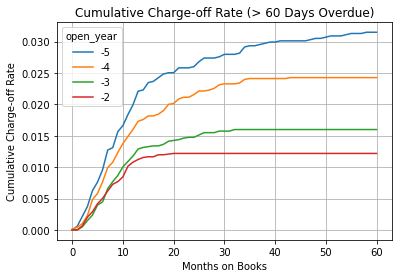

In [36]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
#replace NaN into 0
vintage_graph = vintage_tb.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_tb[lst].T.plot(legend = True, grid = True, title = 'Cumulative Charge-off Rate (> 60 Days Overdue)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative Charge-off Rate')
plt.show()

In [40]:
print(credit_pivot)

MONTHS_BALANCE       ID  open_month  close_month  window_month
0               5001711          -3            0             3
1               5001712         -18            0            18
2               5001713         -21            0            21
3               5001714         -14            0            14
4               5001715         -59            0            59
...                 ...         ...          ...           ...
45980           5150482         -28          -11            17
45981           5150483         -17            0            17
45982           5150484         -12            0            12
45983           5150485          -1            0             1
45984           5150487         -29            0            29

[45985 rows x 4 columns]


In [ ]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

In [ ]:
#
print(app_df.shape)
app_df.head()

In [ ]:
#Join two data frames by ID
sum_df = pd.concat([credit_df,app_df])
#Sort the merged data frame by ID

